In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt, animation, patches
from matplotlib import colorbar, colors
import netCDF4
import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn import cluster
#from libpysal.weights import lat2W
import pysal
from collections import namedtuple
from shapely import geometry

C:\Users\Erik\anaconda3\envs\clustering\lib\site-packages\pysal\lib\weights\util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')
C:\Users\Erik\anaconda3\envs\clustering\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
path = "\\test_data\\"
filename = "EnergyGenerationData\\ERA5-EU_EV-Zuijlen_2019.nc"
fileglob = "energyGenDataMonthly\\ERA5*.nc"
fileglob_sums_dekstop = "ERA5-EU_EV_Zuijlen_summed\\ERA5*.nc"
data_gate3_path = "/media/DataGate3/"
fileglobtotalsums = data_gate3_path + "ERA5-EU_EV-Zuijlen/TotalHourlySum/*.nc"
file_timemeans = "ERA5-EU_EV-Zuijlen_timean.nc"

In [4]:
south_bound = 35#50#
north_bound = 74.75#56#
west_bound = -14.75#2.5#
east_bound = 40#7.5#

### LAT LON BOUNDARIES
#SET UP FOR EU DATA CURRENTLY
lat_slice = slice(south_bound,north_bound)
lon_slice = slice(west_bound,east_bound)


#HPZED:
#xrDS_EU_summed = xr.open_mfdataset(fileglobtotalsums, concat_dim= 'time')

#Desktop:
xrDS_EU = xr.open_dataset(os.getcwd()+path+file_timemeans)
xrDS_EU = xrDS_EU.sel(lat=lat_slice, lon=lon_slice)
xrDS_EU=xrDS_EU.squeeze()


In [5]:
kmeans5 = cluster.KMeans(n_clusters=5)
kmeans10= cluster.KMeans(n_clusters=10)

In [6]:
SPV = xrDS_EU['SPV'].values
WON = xrDS_EU['WON'].values
WOF = xrDS_EU['WOF'].values

In [7]:
data = np.stack([SPV,WON,WOF],axis=2)

In [8]:
xrDS_EU

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 160, lon: 220)
Coordinates:
    time       datetime64[ns] 1984-12-31T18:30:00
  * lon        (lon) float64 -14.75 -14.5 -14.25 -14.0 ... 39.25 39.5 39.75 40.0
  * lat        (lat) float64 35.0 35.25 35.5 35.75 ... 74.0 74.25 74.5 74.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (bnds) datetime64[ns] ...
    SPV        (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    WON        (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    WOF        (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Fri Nov 27 15:01:19 2020: cdo timmean -cat ERA5-EU_EV-Zuijl...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [9]:
x,y,z = data.shape

In [10]:
d2_data=data.reshape((x*y),z)

In [11]:
d2_data.shape

(35200, 3)

# K means clustering

In [12]:
k5cls = kmeans5.fit(d2_data)

In [13]:
clusterres = k5cls.labels_.reshape(x,y)

In [14]:
xrDS_EU['clusters5']=(('lat','lon'),clusterres)

In [15]:
def add_sub_region_box(ax, subregion):
    """ """
    geom = geometry.box(minx=subregion.lonmin,maxx=subregion.lonmax,miny=subregion.latmin,maxy=subregion.latmax)
    feature_artist = ax.add_geometries([geom], crs=cartopy.crs.PlateCarree(), alpha=0.8, edgecolor = "red", facecolor="None", linewidth=3)
    return ax

Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

#Subregion we want to highlight
#currently doesn't show, as frame 0 of the animate overwrites this. 
sub_region =  Region(
        region_name="highlands_region",
        lonmin=-10,
        lonmax=10,
        latmin=50,
        latmax=55
)
southern_spain_cluster =  Region(
        region_name="southern_spain_cluster",
        lonmin=-9,
        lonmax=-0.5,
        latmin=35.5,
        latmax=38.5
)
danish_wof_cluster =  Region(
        region_name="danish_wof_cluster",
        lonmin=4.75,
        lonmax=8,
        latmin=53.75,
        latmax=57.5
)

german_won_cluster =  Region(
        region_name="german_won_cluster",
        lonmin=4.5,
        lonmax=15,
        latmin=50,
        latmax=53.5
)


french_mixed_cluster =  Region(
        region_name="french_mixed_cluster",
        lonmin=-5,
        lonmax=9,
        latmin=42.5,
        latmax=50
)

In [32]:
custom_cmap = matplotlib.colors.ListedColormap(['white',"blue",'cyan','green','orange'])

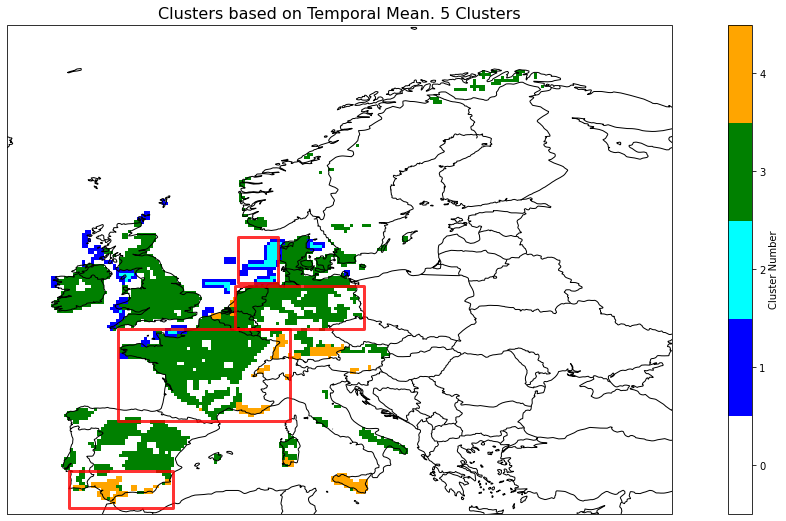

In [35]:
fig=plt.figure(figsize=(20,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
image = xrDS_EU["clusters5"].plot(ax=ax, cmap=custom_cmap, add_colorbar = False)
ax.set_extent([-14, 40, 35, 74.75], ccrs.PlateCarree())
ax.axes.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.axes.add_feature(cfeature.COASTLINE)
plt.title("Clusters based on Temporal Mean. 5 Clusters",fontsize=16)
labels = np.arange(0,5,1)
loc = labels + 0.5
image.set_clim(-0.5, 4.5)
cbar = plt.colorbar(image, orientation='vertical', label ='Cluster Number', spacing = 'uniform')

#cbar.ax.set_ylabel('Cluster number', fontsize = 16, weight="bold")
add_sub_region_box(ax,southern_spain_cluster)
add_sub_region_box(ax,danish_wof_cluster)
add_sub_region_box(ax,german_won_cluster)
add_sub_region_box(ax,french_mixed_cluster)
plt.savefig("clusters5_regions.pdf")

plt.show()

In [58]:
per_cluster_5 = xrDS_EU.groupby("clusters5").mean()

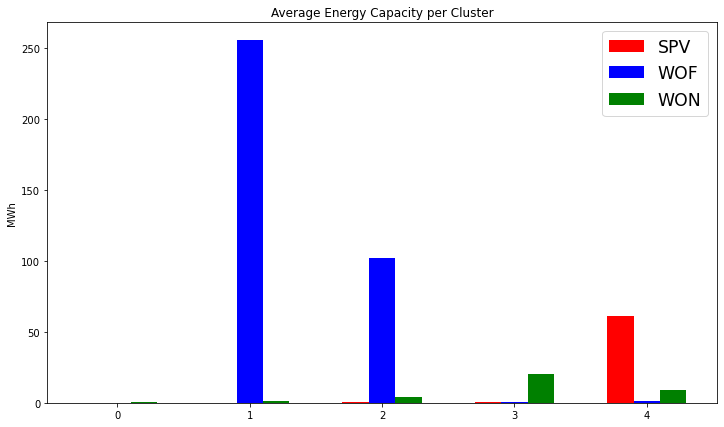

In [85]:
fig = plt.figure(figsize=(12, 7))
xticks = np.arange(5)
width = 0.2
#plt.xticks(range(0,20))
plt.bar(xticks - width, per_cluster_5["SPV"].values, width, color = 'r', label ="SPV")
plt.bar(xticks,per_cluster_5["WOF"].values, width, color = 'b', label = "WOF")
plt.bar(xticks + width,per_cluster_5["WON"].values, width, color = 'g', label = "WON")
plt.legend(fontsize = 'xx-large')
plt.title("Average Energy Capacity per Cluster")
plt.ylabel("MWh")
plt.savefig("cluster_bars.pdf")
plt.show()

In [16]:
k10cls = kmeans10.fit(d2_data)

In [17]:
clusterres10 = k10cls.labels_.reshape(x,y)

In [27]:
xrDS_EU['clusters10']=(('lat','lon'),clusterres10)

Text(0, 0.5, 'Cluster number')

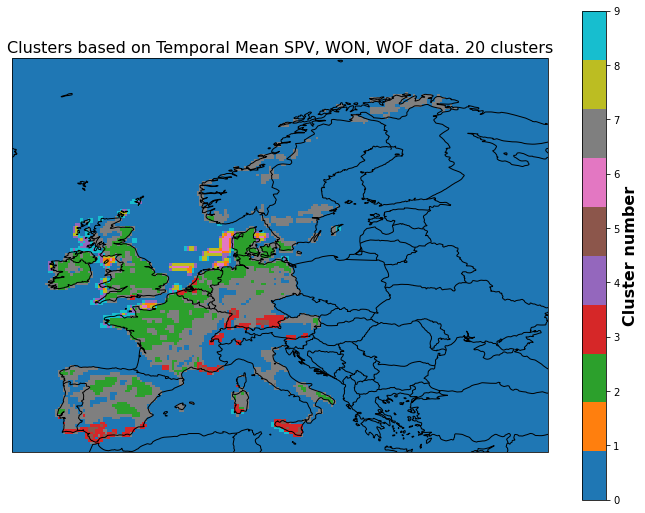

In [28]:
fig=plt.figure(figsize=(12,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
image = xrDS_EU["clusters10"].plot(ax=ax, cmap="tab10", add_colorbar = False)
ax.set_extent([-14, 40, 35, 74.75], ccrs.PlateCarree())
ax.axes.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.axes.add_feature(cfeature.COASTLINE)
plt.title("Clusters based on Temporal Mean SPV, WON, WOF data. 20 clusters",fontsize=16)
cbar = plt.colorbar(image, orientation='vertical', ticks=np.arange(0,10, 1))
cbar.ax.set_ylabel('Cluster number', fontsize = 16, weight="bold")

In [18]:
per_cluster_10 = xrDS_EU.groupby("clusters10").mean()

KeyError: 'clusters10'

NameError: name 'per_cluster_10' is not defined

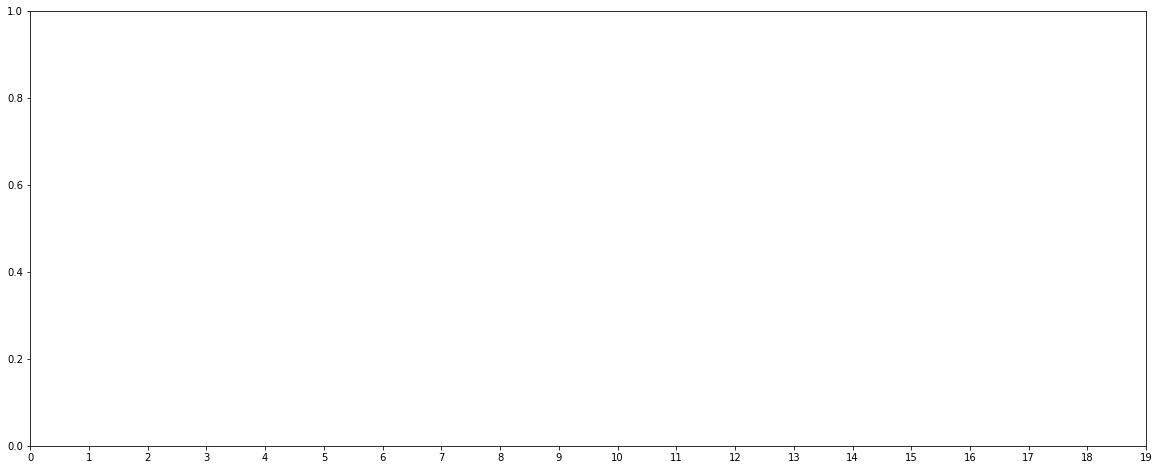

In [19]:
fig = plt.figure(figsize=(20, 8))
plt.xticks(range(0,20))
plt.plot(per_cluster_10["SPV"].values, color = 'r', label ="SPV")
plt.plot(per_cluster_10["WOF"].values, color = 'b', label = "WOF")
plt.plot(per_cluster_10["WON"].values, color = 'g', label = "WON")
plt.legend()

# Agglomerative Clustering

In [20]:
connect_weight = pysal.lib.weights.lat2W(160,220,rook=False)


In [21]:
model = cluster.AgglomerativeClustering(linkage='ward',
                                                connectivity=connect_weight.sparse,
                                                n_clusters=20)

In [22]:
model.fit(d2_data)

AgglomerativeClustering(connectivity=<35200x35200 sparse matrix of type '<class 'numpy.float64'>'
	with 279324 stored elements in Compressed Sparse Row format>,
                        n_clusters=20)

In [23]:
clusters_connected=model.labels_.reshape(x,y)

In [24]:
clusters_connected.shape

(160, 220)

In [25]:
xrDS_EU['clusters_connected']=(('lat','lon'),clusters_connected)

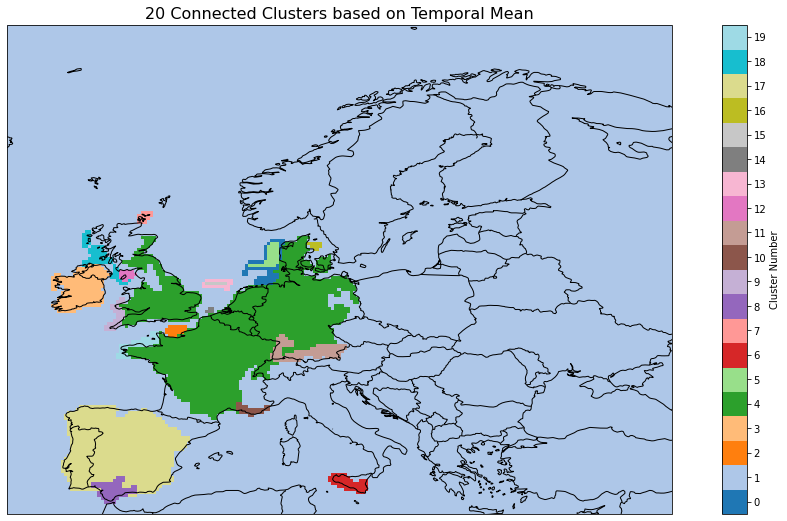

In [26]:
fig=plt.figure(figsize=(18,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
image = xrDS_EU["clusters_connected"].plot(ax=ax, cmap="tab20", add_colorbar = False)
ax.set_extent([-14, 40, 35, 74.75], ccrs.PlateCarree())
ax.axes.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.axes.add_feature(cfeature.COASTLINE)
plt.title("20 Connected Clusters based on Temporal Mean",fontsize=16)

labels = np.arange(0,20,1)
loc = labels + 0.5
image.set_clim(0, 20)
cbar = plt.colorbar(image, orientation='vertical', label ='Cluster Number', spacing = 'uniform')
cbar.set_ticks(loc)
cbar.set_ticklabels(labels)
#plt.savefig("cluster20_connected.pdf")
plt.show()

In [27]:
xrDS_EU.attrs['Clusters'] = "20 Clusters created using sklearn AgglomerativeClustering with ward linkage and queen connectivity matrix"

In [28]:
per_cluster = xrDS_EU.groupby("clusters_connected").mean()

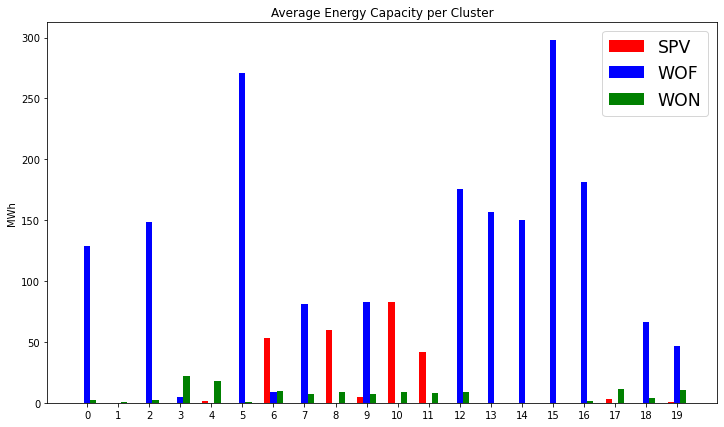

In [30]:
fig = plt.figure(figsize=(12, 7))
x_ticks = np.arange(20)
width = 0.2
#plt.xticks(range(0,20))
plt.bar(x_ticks - width, per_cluster["SPV"].values, width, color = 'r', label ="SPV")
plt.bar(x_ticks,per_cluster["WOF"].values, width, color = 'b', label = "WOF")
plt.bar(x_ticks + width,per_cluster["WON"].values, width, color = 'g', label = "WON")
plt.legend(fontsize = 'xx-large')
plt.title("Average Energy Capacity per Cluster")
plt.ylabel("MWh")
plt.xticks(x_ticks, x_ticks)
# ax.set_xticks(range(19),True)
# ax.set_xticklabels(x_ticks)
plt.savefig("cluster20_connected_bars.pdf")
plt.show()

In [40]:
#xrDS_EU.to_netcdf(path=os.getcwd()+path+"ERA5-EU_EV-Zuijlen_timean_clustered.nc")

In [133]:
del xticks

In [135]:
xticks

NameError: name 'xticks' is not defined